<img src="AW&H2015.tiff" style="float: left">

<img src="flopylogo.png" style="float: center">

# Problem P4.4 Adding Pumping to Hubbertville Areal Model

In Problem P4.3 in Anderson, Woessner and Hunt (2015), we are asked to construct an areal 2D model to assess impacts of pumping.  The town of Hubbertville is planning to expand its water supply by constructing a pumping well in an unconfined gravel aquifer (Fig. P4.3). The well is designed to pump constantly at a rate of 20,000 m3/day. Well construction was halted by the State Fish and Game Service who manage the Green Swamp Conservation area. The agency claimed that pumping would “significantly reduce” groundwater discharge to the swamp and damage waterfowl habitat. The town claimed the fully penetrating river boundary to the north and the groundwater divide located near the center of the valley would prevent any change in flow to the swamp.

In Problem P4.4 on page 174-175, we return to the model you designed for Problem P4.3. Place a well at the location indicated in Fig. P4.3 and pump the well at a constant rate of 20,000 m3/day. Run the model under steady-state pumping conditions three times under each of the following three representations of model boundaries: (1) physical boundaries shown in Fig. P4.3; (2) an internal no-flow boundary at the groundwater divide between the river and the swamp; the location of the divide is determined from the solution of Problem P4.3; (3) an internal specified head boundary at the groundwater divide between the river and the swamp; the location of the divide is determined from the solution of Problem P4.3.


## Part a.
Discuss the effects of the internal boundary conditions imposed on the groundwater divide on the resulting head distributions. Compare northesouth watertable profiles drawn through the node representing the pumping well for the
three pumping simulations. Compute the discharge to the Green Swamp under each set of boundary conditions.

In this notebook, we will work through the problem using MODFLOW and the Python tool set Flopy. Notice how much code is reused from P4.1 because the variable names remained the same.

<img src="P4.3_figure.tiff" style="float: center">

Below is an iPython Notebook that builds a Python MODFLOW model for this problem and plots results. See the Github wiki associated with this Chapter for information on one suggested installation and setup configuration for Python and iPython Notebook.

[Acknowledgements: This tutorial was created by Randy Hunt and all failings are mine.  The exercise here has benefited greatly from the online Flopy tutorial and example notebooks developed by Chris Langevin and Joe Hughes for the USGS Spring 2015 Python Training course GW1774]

## Creating the Model - GW divide simulated (not specified as BC)
This first part of the problem is identical to P4.3, and we will again create a simple groundwater flow model by following the tutorial included on the Flopy website.  We will make a few small changes  so that the tutorial works with our file structure.

Visit the tutorial website [here](http://modflowpy.github.io/flopydoc/tutorial1.html "tutorial").

### Setup the Notebook Environment and Import Flopy
Load a few standard libraries, and then load flopy.

In [1]:
%matplotlib inline
import sys
import os
import shutil
import numpy as np
from subprocess import check_output

# Import flopy
import flopy

### Setup a New Directory and Change Paths
For this tutorial, we will work in a new subdirectory underneath the directory where the notebook is located. We can use some fancy Python tools to help us manage the directory creation. Note that if you encounter path problems with this workbook, you can stop and then restart the kernel and the paths will be reset.

In [2]:
# Set the name of the path to the model working directory
dirname = "P4-4_Hubbertville"
datapath = os.getcwd()
modelpath = os.path.join(datapath, dirname)
print 'Name of model path: ', modelpath

# Now let's check if this directory exists.  If not, then we will create it.
if os.path.exists(modelpath):
    print 'Model working directory already exists.'
else:
    print 'Creating model working directory.'
    os.mkdir(modelpath)

Name of model path:  /Users/rjhunt1/GitHub/Chapter_4_problems-1/P4-4_Hubbertville
Creating model working directory.


### Define the Model Extent, Grid Resolution, and Characteristics
It is normally good practice to group things that you might want to change into a single code block.  This makes it easier to make changes and rerun the code.

In [3]:
# model domain and grid definition
# for clarity, user entered variables are all caps; python syntax are lower case or mixed case
# In a contrast to P4.1 and P4.2, this is an areal 2D model
LX = 4500.
LY = 11000.   # note that there is an added 500m on the top and bottom to represent the boundary conditions,that leaves an aqufier lenght of 10000 m  
ZTOP = 1030.  # the system is unconfined so set the top above land surface so that the water table never > layer top
ZBOT = 980.
NLAY = 1
NROW = 22
NCOL = 9
DELR = LX / NCOL  # recall that MODFLOW convention is DELR is along a row, thus has items = NCOL; see page XXX in AW&H (2015)
DELC = LY / NROW  # recall that MODFLOW convention is DELC is along a column, thus has items = NROW; see page XXX in AW&H (2015)
DELV = (ZTOP - ZBOT) / NLAY
BOTM = np.linspace(ZTOP, ZBOT, NLAY + 1)
HK = 50.
VKA = 1.
RCH = 0.001
#In P4.4 the proposed well is pumping (Q was set to zero in P4.3)
WELLQ = -20000.   #recall MODFLOW convention, negative means pumped out of the model domain (=aquifer)
print "DELR =", DELR, "  DELC =", DELC, '  DELV =', DELV
print "BOTM =", BOTM
print "Recharge =", RCH 
print "Pumping well rate =", WELLQ


DELR = 500.0   DELC = 500.0   DELV = 50.0
BOTM = [ 1030.   980.]
Recharge = 0.001
Pumping well rate = -20000.0


### Create the MODFLOW-NWT Model Object
Create a flopy MODFLOW object: [flopy.modflow.Modflow](http://modflowpy.github.io/flopydoc/mf.html).

Note that in P4.3 we used the older PCG solver with no issues.  Simply adding the new pumping to P4.3 will cause a dry node at the pumping well in some cases below.  Therefore, we are using the MODFLOW-NWT executable instead, which handles dry node problems much better.  Compare these steps below to P4.3: note how similar the input is for MODFLOW-2005 and MODFLOW-NWT.

In [4]:
# Assign name and create modflow model object
modelname = 'P4-4'
#exe_name = os.path.join(datapath, 'mfnwt.exe') # for Windows OS
exe_name = os.path.join(datapath, 'mfnwt')     # for Mac OS
print 'Model executable: ', exe_name
MF = flopy.modflow.Modflow(modelname, exe_name=exe_name, model_ws=modelpath)

Model executable:  /Users/rjhunt1/GitHub/Chapter_4_problems-1/mfnwt


### Discretization Package
Create a flopy discretization package object: [flopy.modflow.ModflowDis](http://modflowpy.github.io/flopydoc/mfdis.html).

In [5]:
# Create the discretization object
TOP = ZTOP * np.ones((NROW, NCOL),dtype=np.float)

In [6]:
DIS_PACKAGE = flopy.modflow.ModflowDis(MF, NLAY, NROW, NCOL, delr=DELR, delc=DELC,
                               top=TOP, botm=BOTM[1:], laycbd=0)
# print DIS_PACKAGE  #uncomment this on far left to see information about the flopy object

### Basic Package
Create a flopy basic package object: [flopy.modflow.ModflowBas](http://modflowpy.github.io/flopydoc/mfbas.html).

In [7]:
# Variables for the BAS package
IBOUND = np.ones((NLAY, NROW, NCOL), dtype=np.int32)  # all nodes are active (IBOUND = 1)

# make the top of the profile specified head by setting the IBOUND = -1
IBOUND[:, 0, :] = -1  #don't forget arrays are zero-based!
IBOUND[:, -1, :] = -1  #-1 is Python for last in array
print IBOUND

[[[-1 -1 -1 -1 -1 -1 -1 -1 -1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [-1 -1 -1 -1 -1 -1 -1 -1 -1]]]


In [8]:
STRT = 1010 * np.ones((NLAY, NROW, NCOL), dtype=np.float32)  # set starting head to 1010 m through out model domain
STRT[:, 0, :] = 1000.       # river stage for setting constant head
STRT[:, -1, :] = 1000.     # wetland stage for setting constant head
print STRT

[[[ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.]
  [ 1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.]
  [ 1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.]
  [ 1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.]
  [ 1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.]
  [ 1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.]
  [ 1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.]
  [ 1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.]
  [ 1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.]
  [ 1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.]
  [ 1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.]
  [ 1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.]
  [ 1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.]
  [ 1010.  1010.  1010.  1010.  1010.  1010.  1010.  1010.  10

In [9]:
BAS_PACKAGE = flopy.modflow.ModflowBas(MF, ibound=IBOUND, strt=STRT)
# print BAS_PACKAGE  # uncomment this at far left to see the information about the flopy BAS object

### Upstream Weighting Package (like Layer Property Flow Package)
Create a flopy layer property flow package object: [flopy.modflow.ModflowUpw](http://modflowpy.github.io/flopydoc/mfupw.html).

In [10]:
LPF_PACKAGE = flopy.modflow.ModflowUpw(MF, laytyp=1, hk=HK, vka=VKA)  # we defined the K and anisotropy at top of file
# print LPF_PACKAGE  # uncomment this at far left to see the information about the flopy LPF object

### Well Package
Create a flopy output control object: [flopy.modflow.ModflowWel](http://modflowpy.github.io/flopydoc/mfwel.html).

In [11]:
WEL_PACKAGE = flopy.modflow.ModflowWel(MF, stress_period_data=[0,4,4,WELLQ])  # remember python 0 index, layer 0 = layer 1 in MF
#print WEL_PACKAGE  # uncomment this at far left to see the information about the flopy WEL object

### Output Control
Create a flopy output control object: [flopy.modflow.ModflowOc](http://modflowpy.github.io/flopydoc/mfoc.html).

In [12]:
OC_PACKAGE = flopy.modflow.ModflowOc(MF)   # we'll use the defaults for the model output
# print OC_PACKAGE  # uncomment this at far left to see the information about the flopy OC object

### Recharge Package
Create a flopy pcg package object: [flopy.modflow.ModflowRch](http://modflowpy.github.io/flopydoc/mfrch.html).

In [13]:
RCH_PACKAGE = flopy.modflow.ModflowRch(MF, rech=RCH)
# print RCH_PACKAGE  # uncomment this at far left to see the information about the flopy RCH object

### Newton-Raphson Solver
Create a flopy pcg package object: [flopy.modflow.ModflowNwt](http://modflowpy.github.io/flopydoc/mfnwt.html).

In [14]:
NWT_PACKAGE = flopy.modflow.ModflowNwt(MF, headtol=0.001, fluxtol=5000, maxiterout=900) 
# print NWT_PACKAGE  # uncomment this at far left to see the information about the flopy PCG object

## Writing the MODFLOW Input Files
Before we create the model input datasets, we can do some directory cleanup to make sure that we don't accidently use old files.

In [15]:
#Before writing input, destroy all files in folder to prevent reusing old files
#Here's the working directory
print modelpath
#Here's what's currently in the working directory
modelfiles = os.listdir(modelpath)
print modelfiles
#delete these files to prevent us from reading old results
modelfiles = os.listdir(modelpath)
for filename in modelfiles:
    f = os.path.join(modelpath, filename)
    if modelname in f:
        try:
            os.remove(f)
            print 'Deleted: ', filename
        except:
            print 'Unable to delete: ', filename
            
#Now write the model input files
MF.write_input()

/Users/rjhunt1/GitHub/Chapter_4_problems-1/P4-4_Hubbertville
[]


## Running the Model

Flopy has several methods attached to the model object that can be used to run the model.  They are run_model, run_model2, and run_model3.  Here we use run_model3, which will write output to the notebook.

In [16]:
silent = False  #Print model output to screen?
pause = False   #Require user to hit enter? Doesn't mean much in Ipython notebook
report = True   #Store the output from the model in buff
success, buff = MF.run_model(silent=silent, pause=pause, report=report)

FloPy is using the following executable to run the model: /Users/rjhunt1/GitHub/Chapter_4_problems-1/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.0.9 07/01/2014                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.03.0 08/30/2013                       

 Using NAME file: P4-4.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2015/09/04 16:17:23

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2015/09/04 16:17:23
 Elapsed run time:  0.004 Seconds

  Normal termination of simulation


## Post Processing the Results
To read heads from the MODFLOW binary output file, we can use the [flopy.utils.binaryfile](http://modflowpy.github.io/flopydoc/binaryfile.html) module. Specifically, we can use the HeadFile object from that module to extract head data arrays. 

In [17]:
#imports for plotting and reading the MODFLOW binary output file
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

#Create the headfile object and grab the results for last time.
headfile = os.path.join(modelpath, modelname + '.hds')
headfileobj = bf.HeadFile(headfile)

#Get a list of times that are contained in the model
times = headfileobj.get_times()
print 'Headfile (' + modelname + '.hds' + ') contains the following list of times: ', times

Headfile (P4-4.hds) contains the following list of times:  [1.0]


In [18]:
#Get a numpy array of heads for totim = 1.0
#The get_data method will extract head data from the binary file.
HEAD = headfileobj.get_data(totim=1.0)

#Print statistics on the head
print 'Head statistics'
print '  min: ', HEAD.min()
print '  max: ', HEAD.max()
print '  std: ', HEAD.std()

Head statistics
  min:  995.023
  max:  1007.9
  std:  2.88027


Contour Levels:  [  995.     995.25   995.5    995.75   996.     996.25   996.5    996.75
   997.     997.25   997.5    997.75   998.     998.25   998.5    998.75
   999.     999.25   999.5    999.75  1000.    1000.25  1000.5   1000.75
  1001.    1001.25  1001.5   1001.75  1002.    1002.25  1002.5   1002.75
  1003.    1003.25  1003.5   1003.75  1004.    1004.25  1004.5   1004.75
  1005.    1005.25  1005.5   1005.75  1006.    1006.25  1006.5   1006.75
  1007.    1007.25  1007.5   1007.75  1008.    1008.25]
Extent of domain:  (250.0, 4250.0, 250.0, 10750.0)


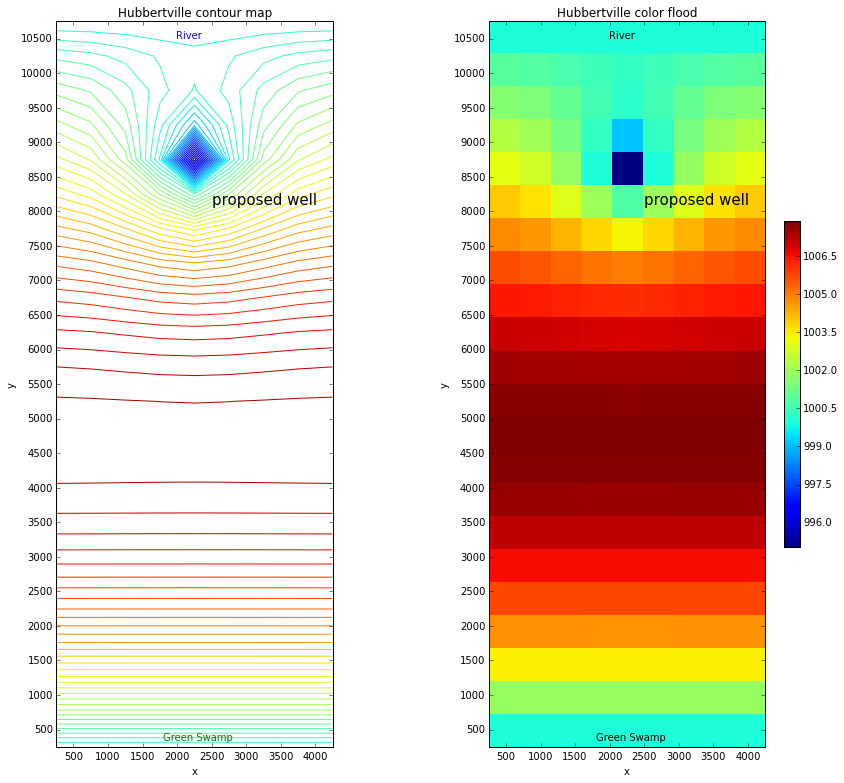

In [19]:
#Create a contour plot of heads
FIG = plt.figure(figsize=(15,13))

#setup contour levels and plot extent
LEVELS = np.arange(995., 1008.5, 0.25)
EXTENT = (DELR/2., LX - DELR/2., DELC/2., LY - DELC/2.)
print 'Contour Levels: ', LEVELS
print 'Extent of domain: ', EXTENT

#Make a contour plot on the first axis
AX1 = FIG.add_subplot(1, 2, 1, aspect='equal')
AX1.set_xlabel("x")
AX1.set_ylabel("y")
YTICKS = np.arange(0, 11000, 500)
AX1.set_yticks(YTICKS)
AX1.set_title("Hubbertville contour map")
AX1.text(2500, 8100, r"proposed well", fontsize=15, color="black")
AX1.text(2000, 10500, r"River", fontsize=10, color="blue")
AX1.text(1800, 340, r"Green Swamp", fontsize=10, color="green")
AX1.contour(np.flipud(HEAD[0, :, :]), levels=LEVELS, extent=EXTENT)

#Make a color flood on the second axis
AX2 = FIG.add_subplot(1, 2, 2, aspect='equal')
AX2.set_xlabel("x")
AX2.set_ylabel("y")
AX2.set_yticks(YTICKS)
AX2.set_title("Hubbertville color flood")
AX2.text(2500, 8100, r"proposed well", fontsize=15, color="black")
AX2.text(2000, 10500, r"River", fontsize=10, color="black")
AX2.text(1800, 340, r"Green Swamp", fontsize=10, color="black")
cax = AX2.imshow(HEAD[0, :, :], extent=EXTENT, interpolation='nearest')
cbar = FIG.colorbar(cax, orientation='vertical', shrink=0.45)


Look at the bottom of the MODFLOW output file (ending with a *.list) and note the water balance reported. 

In [20]:
#look at the head in column = 4 from headobj, and then plot it
#print HEAD along a column; COL is a variable that allows us to change this easily
COL = 4
print HEAD[0,:,COL]

[ 1000.          1000.34960938  1000.22637939   999.10528564   995.02331543
  1000.78540039  1003.42279053  1005.01513672  1006.10760498  1006.88348389
  1007.41729736  1007.74334717  1007.87799072  1007.82806396  1007.59570312
  1007.17889404  1006.57092285  1005.76055908  1004.73040771  1003.45507812
  1001.89715576  1000.        ]


In [21]:
# we see this is what we want, but is flipped because MODFLOW's array does not = Python, so we reverse the order (flip them) and call it 
Y = np.flipud(HEAD[0,:,COL])
print Y

[ 1000.          1001.89715576  1003.45507812  1004.73040771  1005.76055908
  1006.57092285  1007.17889404  1007.59570312  1007.82806396  1007.87799072
  1007.74334717  1007.41729736  1006.88348389  1006.10760498  1005.01513672
  1003.42279053  1000.78540039   995.02331543   999.10528564  1000.22637939
  1000.34960938  1000.        ]


In [22]:
#for our cross section create X-coordinates to match with heads
XCOORD = np.arange(0, 11000, 500) + 250
print XCOORD

[  250   750  1250  1750  2250  2750  3250  3750  4250  4750  5250  5750
  6250  6750  7250  7750  8250  8750  9250  9750 10250 10750]


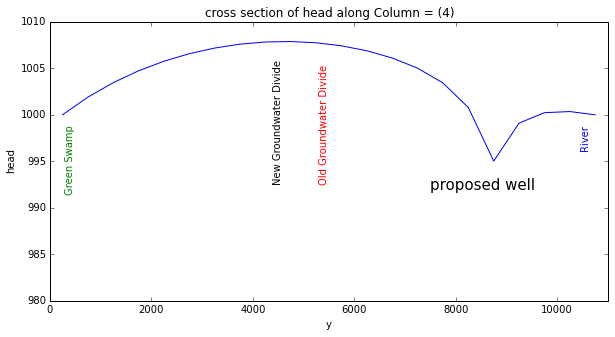

In [23]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
TITLE =  'cross section of head along Column = ({0})'.format(COL)
ax.set_title(TITLE)
ax.set_xlabel('y')
ax.set_ylabel('head')
ax.set_xlim(0, 11000.)
ax.set_ylim(980.,1010.)
ax.text(7500, 992, r"proposed well", fontsize=15, color="black")
ax.text(10480, 998, r"River", fontsize=10, color="blue",rotation='vertical')
ax.text(300, 998, r"Green Swamp", fontsize=10, color="green",rotation='vertical')
ax.text(5300,1004.5, r"Old Groundwater Divide", fontsize=10, color="red",rotation='vertical')
ax.text(4400,1005., r"New Groundwater Divide", fontsize=10, color="black",rotation='vertical')
ax.plot(XCOORD, Y)

In [24]:
#calculate the flux to Green Swamp
HEAD_ADJACENT_CELLS = HEAD[0,-2,:]
print "heads in cells next to Green Swamp =", HEAD_ADJACENT_CELLS
FLUX_TO_SWAMP = 0
THICK = (HEAD[0,-2,5]+1000.)/2 - ZBOT   #the thickness is approximated using the average saturated thickness
for NODEHEAD in HEAD_ADJACENT_CELLS:
    NODEFLUX = (HK * (NODEHEAD-1000.)/(DELC) * DELR * THICK) # Q = KIA
    FLUX_TO_SWAMP += NODEFLUX
    print 'gradient =', (NODEHEAD-1000)/(DELC), '  Kh =', HK, '  thickness=', THICK, ' Grid spacing =', DELC, ' Node flux =', NODEFLUX
print "Total Flux to Swamp =", FLUX_TO_SWAMP, "cubic meters per day"

heads in cells next to Green Swamp = [ 1001.8972168   1001.8972168   1001.89715576  1001.89715576  1001.89715576
  1001.89715576  1001.89715576  1001.8972168   1001.8972168 ]
gradient = 0.00379443359375   Kh = 50.0   thickness= 20.9485778809  Grid spacing = 500.0  Node flux = 1987.19969131
gradient = 0.00379443359375   Kh = 50.0   thickness= 20.9485778809  Grid spacing = 500.0  Node flux = 1987.19969131
gradient = 0.00379431152344   Kh = 50.0   thickness= 20.9485778809  Grid spacing = 500.0  Node flux = 1987.13576132
gradient = 0.00379431152344   Kh = 50.0   thickness= 20.9485778809  Grid spacing = 500.0  Node flux = 1987.13576132
gradient = 0.00379431152344   Kh = 50.0   thickness= 20.9485778809  Grid spacing = 500.0  Node flux = 1987.13576132
gradient = 0.00379431152344   Kh = 50.0   thickness= 20.9485778809  Grid spacing = 500.0  Node flux = 1987.13576132
gradient = 0.00379431152344   Kh = 50.0   thickness= 20.9485778809  Grid spacing = 500.0  Node flux = 1987.13576132
gradient = 0.

In [25]:
#calculate the flux to River
HEAD_ADJACENT_CELLS = HEAD[0,1,:]
print "heads in cells next to River =", HEAD_ADJACENT_CELLS
FLUX_TO_RIVER = 0
THICK = (HEAD[0,-2,5]+1000.)/2 - ZBOT   #the thickness is approximated using the average saturated thickness
for NODEHEAD in HEAD_ADJACENT_CELLS:
    NODEFLUX = (HK * (NODEHEAD-1000.)/(DELC) * DELR * THICK) # Q = KIA
    FLUX_TO_RIVER += NODEFLUX
    print 'gradient =', (NODEHEAD-1000)/(DELC), '  Kh =', HK, '  thickness=', THICK, ' Grid spacing =', DELC, ' Node flux =', NODEFLUX
print "Total Flux to River =", FLUX_TO_RIVER, "cubic meters per day"

heads in cells next to River = [ 1000.91821289  1000.82678223  1000.65869141  1000.46252441  1000.34960938
  1000.46252441  1000.65869141  1000.82678223  1000.91821289]
gradient = 0.00183642578125   Kh = 50.0   thickness= 20.9485778809  Grid spacing = 500.0  Node flux = 961.762712523
gradient = 0.00165356445312   Kh = 50.0   thickness= 20.9485778809  Grid spacing = 500.0  Node flux = 865.995593183
gradient = 0.0013173828125   Kh = 50.0   thickness= 20.9485778809  Grid spacing = 500.0  Node flux = 689.932411164
gradient = 0.000925048828125   Kh = 50.0   thickness= 20.9485778809  Grid spacing = 500.0  Node flux = 484.461435489
gradient = 0.00069921875   Kh = 50.0   thickness= 20.9485778809  Grid spacing = 500.0  Node flux = 366.190961003
gradient = 0.000925048828125   Kh = 50.0   thickness= 20.9485778809  Grid spacing = 500.0  Node flux = 484.461435489
gradient = 0.0013173828125   Kh = 50.0   thickness= 20.9485778809  Grid spacing = 500.0  Node flux = 689.932411164
gradient = 0.001653564

In [26]:
print 'Flux to Green Swamp =', FLUX_TO_SWAMP, 'Flux to River =', FLUX_TO_RIVER
BCFLUX = FLUX_TO_SWAMP + FLUX_TO_RIVER
Q = WELLQ * -1
print 'Flux to perimeter boundaries =', BCFLUX, ', Well pumping =', Q, ', Total Vol Out =', BCFLUX+Q, 'cubic meters per day'

Flux to Green Swamp = 17884.4775719 Flux to River = 6370.49526572
Flux to perimeter boundaries = 24254.9728376 , Well pumping = 20000.0 , Total Vol Out = 44254.9728376 cubic meters per day


## Testing your Skills

1.  Is the total volumetric flux out near that reported in the MODFLOW list file?

2.  Experiment with horizontal grid resolution, well location, recharge, pumping rate, and aquifer characteristics.  Rerun the model and post process to evaluate the effects.

# P4.3 Part a.  GW divide as No-flow and Specified Head BCs

Using the steady-state heads derived in P4.3, run the model using first a no-flow boundary and then a specified head boundary at the location of the groundwater divide. Compare results with those in part (a). Compute the discharge to Green Swamp under each representation. What is the effect of assigning an internal boundary on the results?

## GW divide as No-flow BC

In [27]:
# recall from P4.3 that the GW divide was located at Rows 10 and 11; 
# where each head value in the column was 1005.50
#like P4.3, lets set Rows 10 and 11 to no flow
#(set that row to 0 in the MODFLOW IBOUND array)
IBOUND[:, 10, :] = 0  
IBOUND[:, 11, :] = 0 
print IBOUND

[[[-1 -1 -1 -1 -1 -1 -1 -1 -1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [-1 -1 -1 -1 -1 -1 -1 -1 -1]]]


In [28]:
#we have to update the MODFLOW's BAS Package with the new IBOUND array 
BAS_PACKAGE = flopy.modflow.ModflowBas(MF, ibound=IBOUND, strt=STRT)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


In [29]:
#Before writing input, destroy all files in folder to prevent reusing old files
#Here's the working directory
print modelpath
#Here's what's currently in the working directory
modelfiles = os.listdir(modelpath)
print modelfiles

/Users/rjhunt1/GitHub/Chapter_4_problems-1/P4-4_Hubbertville
['P4-4.bas', 'P4-4.cbc', 'P4-4.ddn', 'P4-4.dis', 'P4-4.hds', 'P4-4.list', 'P4-4.nam', 'P4-4.nwt', 'P4-4.oc', 'P4-4.rch', 'P4-4.upw', 'P4-4.wel']


In [30]:
#delete these files to prevent us from reading old results
modelfiles = os.listdir(modelpath)
for filename in modelfiles:
    f = os.path.join(modelpath, filename)
    if modelname in f:
        try:
            os.remove(f)
            print 'Deleted: ', filename
        except:
            print 'Unable to delete: ', filename

Deleted:  P4-4.bas
Deleted:  P4-4.cbc
Deleted:  P4-4.ddn
Deleted:  P4-4.dis
Deleted:  P4-4.hds
Deleted:  P4-4.list
Deleted:  P4-4.nam
Deleted:  P4-4.nwt
Deleted:  P4-4.oc
Deleted:  P4-4.rch
Deleted:  P4-4.upw
Deleted:  P4-4.wel


In [31]:
#Now write the model input files
MF.write_input()
print "New MODFLOW input files = ", modelfiles
print "You can check the newly created files in", modelpath


New MODFLOW input files =  ['P4-4.bas', 'P4-4.cbc', 'P4-4.ddn', 'P4-4.dis', 'P4-4.hds', 'P4-4.list', 'P4-4.nam', 'P4-4.nwt', 'P4-4.oc', 'P4-4.rch', 'P4-4.upw', 'P4-4.wel']
You can check the newly created files in /Users/rjhunt1/GitHub/Chapter_4_problems-1/P4-4_Hubbertville


In [32]:
#rerun MODFLOW-2005
silent = False  #Print model output to screen?
pause = False   #Require user to hit enter? Doesn't mean much in Ipython notebook
report = True   #Store the output from the model in buff
success, buff = MF.run_model(silent=silent, pause=pause, report=report)

FloPy is using the following executable to run the model: /Users/rjhunt1/GitHub/Chapter_4_problems-1/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.0.9 07/01/2014                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.03.0 08/30/2013                       

 Using NAME file: P4-4.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2015/09/04 16:17:24

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2015/09/04 16:17:24
 Elapsed run time:  0.005 Seconds

  Normal termination of simulation


In [33]:
#As before, let's look at the results and compare to P4-3 Part a.
#imports for plotting and reading the MODFLOW binary output file
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

#Create the headfile object and grab the results for last time.
headfile = os.path.join(modelpath, modelname + '.hds')
headfileobj = bf.HeadFile(headfile)

#Get a list of times that are contained in the model
times = headfileobj.get_times()
print 'Headfile (' + modelname + '.hds' + ') contains the following list of times: ', times

#Get a numpy array of heads for totim = 1.0
#The get_data method will extract head data from the binary file.
HEAD = headfileobj.get_data(totim=1.0)

#Print statistics on the head
print 'Head statistics'
print '  min: ', HEAD.min()
print '  max: ', HEAD.max()
print '  std: ', HEAD.std()

Headfile (P4-4.hds) contains the following list of times:  [1.0]
Head statistics
  min:  -999.99
  max:  1008.95
  std:  575.861


Contour Levels:  [  987.    987.5   988.    988.5   989.    989.5   990.    990.5   991.
   991.5   992.    992.5   993.    993.5   994.    994.5   995.    995.5
   996.    996.5   997.    997.5   998.    998.5   999.    999.5  1000.
  1000.5  1001.   1001.5  1002.   1002.5  1003.   1003.5  1004.   1004.5
  1005.   1005.5  1006.   1006.5  1007.   1007.5  1008.   1008.5]
Extent of domain:  (250.0, 4250.0, 250.0, 10750.0)


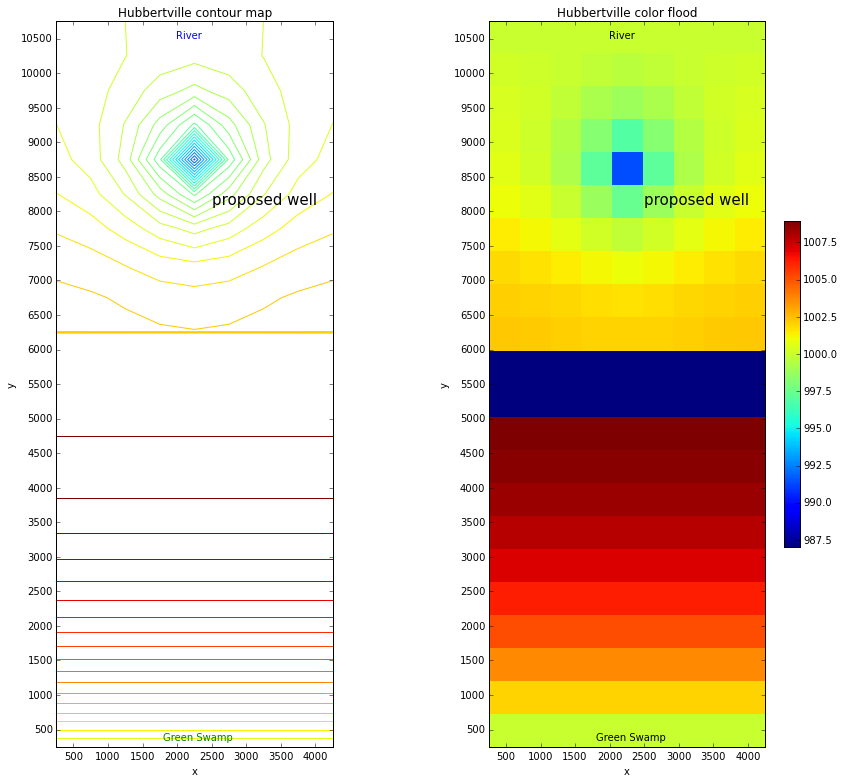

In [34]:
#-999.99 is the Inactive node flag so we'll use our previous contour settings
#Create a contour plot of heads
FIG = plt.figure(figsize=(15,13))

#setup contour levels and plot extent
LEVELS = np.arange(987., 1009., 0.5)
EXTENT = (DELR/2., LX - DELR/2., DELC/2., LY - DELC/2.)
print 'Contour Levels: ', LEVELS
print 'Extent of domain: ', EXTENT

#Make a contour plot on the first axis
AX1 = FIG.add_subplot(1, 2, 1, aspect='equal')
AX1.set_xlabel("x")
AX1.set_ylabel("y")
YTICKS = np.arange(0, 11000, 500)
AX1.set_yticks(YTICKS)
AX1.set_title("Hubbertville contour map")
AX1.text(2500, 8100, r"proposed well", fontsize=15, color="black")
AX1.text(2000, 10500, r"River", fontsize=10, color="blue")
AX1.text(1800, 340, r"Green Swamp", fontsize=10, color="green")
AX1.contour(np.flipud(HEAD[0, :, :]), levels=LEVELS, extent=EXTENT)

#Make a color flood on the second axis
AX2 = FIG.add_subplot(1, 2, 2, aspect='equal')
AX2.set_xlabel("x")
AX2.set_ylabel("y")
AX2.set_yticks(YTICKS)
AX2.set_title("Hubbertville color flood")
AX2.text(2500, 8100, r"proposed well", fontsize=15, color="black")
AX2.text(2000, 10500, r"River", fontsize=10, color="black")
AX2.text(1800, 340, r"Green Swamp", fontsize=10, color="black")
cax = AX2.imshow(HEAD[0, :, :], extent=EXTENT, interpolation='nearest', vmin=987.)
cbar = FIG.colorbar(cax, orientation='vertical', shrink=0.45)

[ 1000.          1002.04156494  1003.72741699  1005.1206665   1006.26300049
  1007.18267822  1007.89953613  1008.42718506  1008.77471924  1008.94744873
  -999.98999023  -999.98999023  1002.02508545  1001.71868896  1001.0456543
   999.81378174   997.41119385   991.3916626    996.89422607   998.85211182
   999.6786499   1000.        ]
[  250   750  1250  1750  2250  2750  3250  3750  4250  4750  5250  5750
  6250  6750  7250  7750  8250  8750  9250  9750 10250 10750]


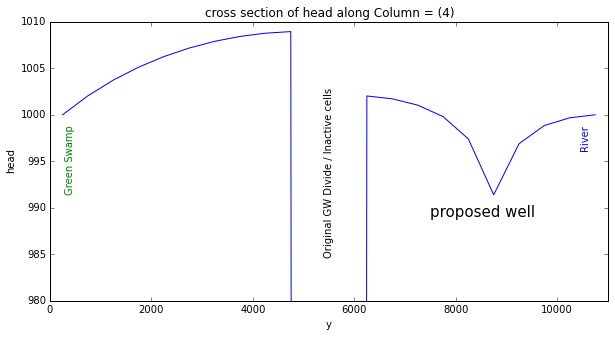

In [35]:
COL = 4
# recall we need to flip because MODFLOW's array does not = Python, so we reverse the order (flip them) and call it 
Y = np.flipud(HEAD[0,:,COL])
print Y
#for our cross section create X-coordinates to match with heads
XCOORD = np.arange(0, 11000, 500) + 250
print XCOORD
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
TITLE =  'cross section of head along Column = ({0})'.format(COL)
ax.set_title(TITLE)
ax.set_xlabel('y')
ax.set_ylabel('head')
ax.set_xlim(0, 11000.)
ax.set_ylim(980.,1010.)
ax.text(7500, 989, r"proposed well", fontsize=15, color="black")
ax.text(10480, 998, r"River", fontsize=10, color="blue",rotation='vertical')
ax.text(300, 998, r"Green Swamp", fontsize=10, color="green",rotation='vertical')
ax.text(5400,1002., r"Original GW Divide / Inactive cells", fontsize=10, color="black",rotation='vertical')
ax.plot(XCOORD, Y)

In [36]:
#calculate the flux to Green Swamp
HEAD_ADJACENT_CELLS = HEAD[0,-2,:]
print "heads in cells next to Green Swamp =", HEAD_ADJACENT_CELLS
FLUX_TO_SWAMP_NO_FLOW = 0
THICK = (HEAD[0,-2,5]+1000.)/2 - ZBOT   #the thickness is approximated using the average saturated thickness
for NODEHEAD in HEAD_ADJACENT_CELLS:
    NODEFLUX = (HK * (NODEHEAD-1000.)/(DELC) * DELR * THICK) # Q = KIA
    FLUX_TO_SWAMP_NO_FLOW += NODEFLUX
    print 'gradient =', (NODEHEAD-1000)/(DELC), '  Kh =', HK, '  thickness=', THICK, ' Grid spacing =', DELC, ' Node flux =', NODEFLUX
print "Total Flux to Swamp (No Flow) =", FLUX_TO_SWAMP_NO_FLOW, "cubic meters per day"

heads in cells next to Green Swamp = [ 1002.04156494  1002.04156494  1002.04156494  1002.04156494  1002.04156494
  1002.04156494  1002.04156494  1002.04156494  1002.04156494]
gradient = 0.00408312988281   Kh = 50.0   thickness= 21.0207824707  Grid spacing = 500.0  Node flux = 2145.76462666
gradient = 0.00408312988281   Kh = 50.0   thickness= 21.0207824707  Grid spacing = 500.0  Node flux = 2145.76462666
gradient = 0.00408312988281   Kh = 50.0   thickness= 21.0207824707  Grid spacing = 500.0  Node flux = 2145.76462666
gradient = 0.00408312988281   Kh = 50.0   thickness= 21.0207824707  Grid spacing = 500.0  Node flux = 2145.76462666
gradient = 0.00408312988281   Kh = 50.0   thickness= 21.0207824707  Grid spacing = 500.0  Node flux = 2145.76462666
gradient = 0.00408312988281   Kh = 50.0   thickness= 21.0207824707  Grid spacing = 500.0  Node flux = 2145.76462666
gradient = 0.00408312988281   Kh = 50.0   thickness= 21.0207824707  Grid spacing = 500.0  Node flux = 2145.76462666
gradient = 0.

## GW divide as Specified Head BC

In [37]:
# Rows 10 and 11 had highest heads (1005.5); reset Rows 10 and 11 to a  specified head boundary (set that row to -1 in the MODFLOW IBOUND array)
IBOUND[:, 10, :] = -1 
IBOUND[:, 11, :] = -1 
print IBOUND

[[[-1 -1 -1 -1 -1 -1 -1 -1 -1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [-1 -1 -1 -1 -1 -1 -1 -1 -1]
  [-1 -1 -1 -1 -1 -1 -1 -1 -1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [-1 -1 -1 -1 -1 -1 -1 -1 -1]]]


In [38]:
#MODFLOW uses the starting heads to set the specified head boundary elevations
#we need to reset the starting heads in Rows 10 and 11 to what they were originally
# in P4.3, which is 1010.83233643
STRT[:, 10, :] = 1010.83233643
STRT[:, 11, :] = 1010.83233643
print STRT

[[[ 1000.          1000.          1000.          1000.          1000.
    1000.          1000.          1000.          1000.        ]
  [ 1010.          1010.          1010.          1010.          1010.
    1010.          1010.          1010.          1010.        ]
  [ 1010.          1010.          1010.          1010.          1010.
    1010.          1010.          1010.          1010.        ]
  [ 1010.          1010.          1010.          1010.          1010.
    1010.          1010.          1010.          1010.        ]
  [ 1010.          1010.          1010.          1010.          1010.
    1010.          1010.          1010.          1010.        ]
  [ 1010.          1010.          1010.          1010.          1010.
    1010.          1010.          1010.          1010.        ]
  [ 1010.          1010.          1010.          1010.          1010.
    1010.          1010.          1010.          1010.        ]
  [ 1010.          1010.          1010.          1010.        

In [39]:
#we have to update the MODFLOW's BAS Package with the new STRT heads 
BAS_PACKAGE = flopy.modflow.ModflowBas(MF, ibound=IBOUND, strt=STRT)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


In [40]:
#delete old files to prevent us from reading old results
modelfiles = os.listdir(modelpath)
for filename in modelfiles:
    f = os.path.join(modelpath, filename)
    if modelname in f:
        try:
            os.remove(f)
            print 'Deleted: ', filename
        except:
            print 'Unable to delete: ', filename

Deleted:  P4-4.bas
Deleted:  P4-4.cbc
Deleted:  P4-4.ddn
Deleted:  P4-4.dis
Deleted:  P4-4.hds
Deleted:  P4-4.list
Deleted:  P4-4.nam
Deleted:  P4-4.nwt
Deleted:  P4-4.oc
Deleted:  P4-4.rch
Deleted:  P4-4.upw
Deleted:  P4-4.wel


In [41]:
#Now write the model input files
MF.write_input()
print "New MODFLOW input files = ", modelfiles
print "You can check the newly created files in", modelpath


New MODFLOW input files =  ['P4-4.bas', 'P4-4.cbc', 'P4-4.ddn', 'P4-4.dis', 'P4-4.hds', 'P4-4.list', 'P4-4.nam', 'P4-4.nwt', 'P4-4.oc', 'P4-4.rch', 'P4-4.upw', 'P4-4.wel']
You can check the newly created files in /Users/rjhunt1/GitHub/Chapter_4_problems-1/P4-4_Hubbertville


In [42]:
#rerun MODFLOW-2005
silent = False  #Print model output to screen?
pause = False   #Require user to hit enter? Doesn't mean much in Ipython notebook
report = True   #Store the output from the model in buff
success, buff = MF.run_model(silent=silent, pause=pause, report=report)

FloPy is using the following executable to run the model: /Users/rjhunt1/GitHub/Chapter_4_problems-1/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.0.9 07/01/2014                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.03.0 08/30/2013                       

 Using NAME file: P4-4.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2015/09/04 16:17:25

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2015/09/04 16:17:25
 Elapsed run time:  0.004 Seconds

  Normal termination of simulation


In [43]:
#As before, let's look at the results and compare to P4-3 Part a.
#imports for plotting and reading the MODFLOW binary output file
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

#Create the headfile object and grab the results for last time.
headfile = os.path.join(modelpath, modelname + '.hds')
headfileobj = bf.HeadFile(headfile)

#Get a list of times that are contained in the model
times = headfileobj.get_times()
print 'Headfile (' + modelname + '.hds' + ') contains the following list of times: ', times

#Get a numpy array of heads for totim = 1.0
#The get_data method will extract head data from the binary file.
HEAD = headfileobj.get_data(totim=1.0)

#Print statistics on the head
print 'Head statistics'
print '  min: ', HEAD.min()
print '  max: ', HEAD.max()
print '  std: ', HEAD.std()

Headfile (P4-4.hds) contains the following list of times:  [1.0]
Head statistics
  min:  997.331
  max:  1010.83
  std:  3.71703


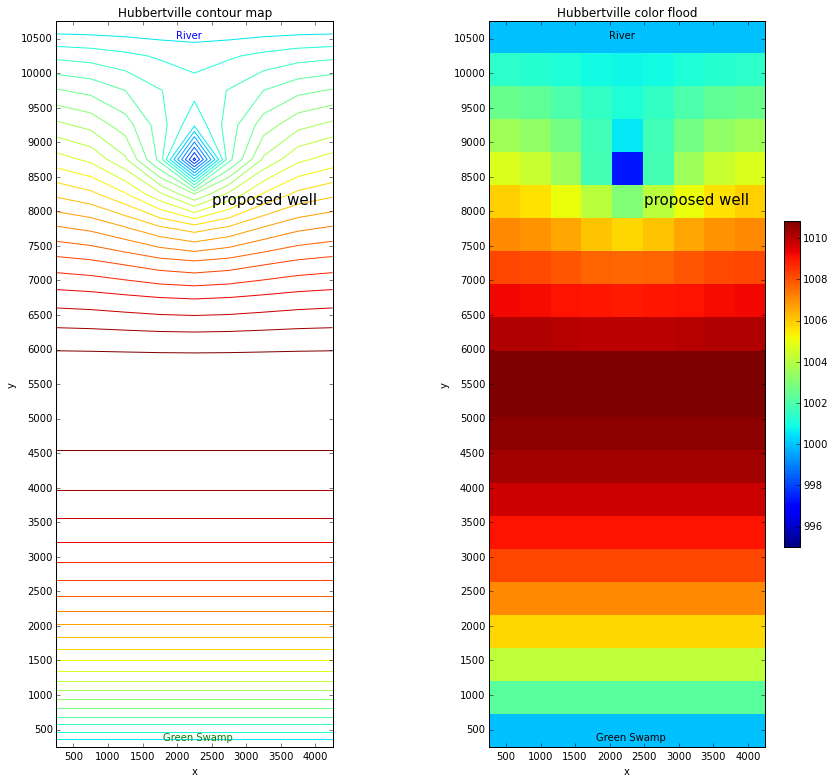

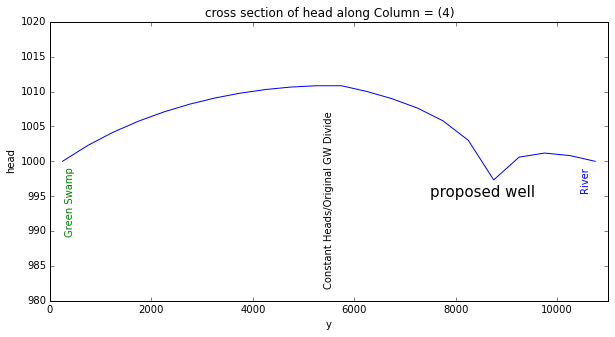

In [44]:
#Create a contour plot of heads
FIG = plt.figure(figsize=(15,13))

#setup contour levels and plot extent
LEVELS = np.arange(995., 1011., 0.5)
EXTENT = (DELR/2., LX - DELR/2., DELC/2., LY - DELC/2.)

#Make a contour plot on the first axis
AX1 = FIG.add_subplot(1, 2, 1, aspect='equal')
AX1.set_xlabel("x")
AX1.set_ylabel("y")
YTICKS = np.arange(0, 11000, 500)
AX1.set_yticks(YTICKS)
AX1.set_title("Hubbertville contour map")
AX1.text(2500, 8100, r"proposed well", fontsize=15, color="black")
AX1.text(2000, 10500, r"River", fontsize=10, color="blue")
AX1.text(1800, 340, r"Green Swamp", fontsize=10, color="green")
AX1.contour(np.flipud(HEAD[0, :, :]), levels=LEVELS, extent=EXTENT)

#Make a color flood on the second axis
AX2 = FIG.add_subplot(1, 2, 2, aspect='equal')
AX2.set_xlabel("x")
AX2.set_ylabel("y")
AX2.set_yticks(YTICKS)
AX2.set_title("Hubbertville color flood")
AX2.text(2500, 8100, r"proposed well", fontsize=15, color="black")
AX2.text(2000, 10500, r"River", fontsize=10, color="black")
AX2.text(1800, 340, r"Green Swamp", fontsize=10, color="black")
cax = AX2.imshow(HEAD[0, :, :], extent=EXTENT, interpolation='nearest', vmin=995.)
cbar = FIG.colorbar(cax, orientation='vertical', shrink=0.45)

#as before let's plot a north-south cross section
COL = 4
# recall we need to flip because MODFLOW's array does not = Python, so we reverse the order (flip them) and call it 
Y = np.flipud(HEAD[0,:,COL])
#for our cross section create X-coordinates to match with heads
XCOORD = np.arange(0, 11000, 500) + 250
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
TITLE =  'cross section of head along Column = ({0})'.format(COL)
ax.set_title(TITLE)
ax.set_xlabel('y')
ax.set_ylabel('head')
ax.set_xlim(0, 11000.)
ax.set_ylim(980.,1020.)
ax.text(7500, 995, r"proposed well", fontsize=15, color="black")
ax.text(10480, 998, r"River", fontsize=10, color="blue",rotation='vertical')
ax.text(300, 998, r"Green Swamp", fontsize=10, color="green",rotation='vertical')
ax.text(5400,1006., r"Constant Heads/Original GW Divide", fontsize=10, color="black",rotation='vertical')
ax.plot(XCOORD, Y)

In [45]:
#calculate the flux to Green Swamp
HEAD_ADJACENT_CELLS = HEAD[0,-2,:]
print "heads in cells next to Green Swamp =", HEAD_ADJACENT_CELLS
FLUX_TO_SWAMP_SPEC_HEAD = 0
THICK = (HEAD[0,-2,5]+1000.)/2 - ZBOT   #the thickness is approximated using the average saturated thickness
for NODEHEAD in HEAD_ADJACENT_CELLS:
    NODEFLUX = (HK * (NODEHEAD-1000.)/(DELC) * DELR * THICK) # Q = KIA
    FLUX_TO_SWAMP_SPEC_HEAD += NODEFLUX
    print 'gradient =', (NODEHEAD-1000)/(DELC), '  Kh =', HK, '  thickness=', THICK, ' Grid spacing =', DELC, ' Node flux =', NODEFLUX
print "Total Flux to Swamp (Specified Head) =", FLUX_TO_SWAMP_SPEC_HEAD, "cubic meters per day"

heads in cells next to Green Swamp = [ 1002.28125  1002.28125  1002.28125  1002.28125  1002.28125  1002.28125
  1002.28125  1002.28125  1002.28125]
gradient = 0.0045625   Kh = 50.0   thickness= 21.140625  Grid spacing = 500.0  Node flux = 2411.35253906
gradient = 0.0045625   Kh = 50.0   thickness= 21.140625  Grid spacing = 500.0  Node flux = 2411.35253906
gradient = 0.0045625   Kh = 50.0   thickness= 21.140625  Grid spacing = 500.0  Node flux = 2411.35253906
gradient = 0.0045625   Kh = 50.0   thickness= 21.140625  Grid spacing = 500.0  Node flux = 2411.35253906
gradient = 0.0045625   Kh = 50.0   thickness= 21.140625  Grid spacing = 500.0  Node flux = 2411.35253906
gradient = 0.0045625   Kh = 50.0   thickness= 21.140625  Grid spacing = 500.0  Node flux = 2411.35253906
gradient = 0.0045625   Kh = 50.0   thickness= 21.140625  Grid spacing = 500.0  Node flux = 2411.35253906
gradient = 0.0045625   Kh = 50.0   thickness= 21.140625  Grid spacing = 500.0  Node flux = 2411.35253906
gradient = 0

### P4.4 Part b
Compare groundwater discharge to the swamp under the prepumping scenario in Problem P4.3 with the results under the pumping scenarios. In light of the modeling results, consider what might be meant by “significantly reduced” as used by the state agency (see discussion in Problem P4.3). Make a list of physical, geochemical and ecological conditions that potentially could be affected by a change in groundwater flow to the Green Swamp.

In [46]:
#let's compare the three formulations:  
#1) gw divide simulated; 2) gw divide as no flow BC; and 3) gw divide as specified head BC
print "P4.3 Flux to Swamp (no pumping/simulated/specified head) =", 22570
print "Correct New Flux to Swamp (pumping/simulated divide) =", FLUX_TO_SWAMP
print "Correct percent flux reduction =", 100 * (FLUX_TO_SWAMP-22570)/22570
print ""
print "Incorrect New Flux to Swamp (pumping/spec head divide) = ", FLUX_TO_SWAMP_SPEC_HEAD
print "Incorrect percent flux reduction =", 100 * (FLUX_TO_SWAMP_SPEC_HEAD-22570)/22570
print ""
print "P4.3 Flux to Swamp (no pumping/no flow divide) =", 20302
print "Incorrect New Flux to Swamp (pumping/no flow divide) = ", FLUX_TO_SWAMP_NO_FLOW
print "Incorrect percent flux reduction =", 100 * (FLUX_TO_SWAMP_NO_FLOW-20302)/20302



P4.3 Flux to Swamp (no pumping/simulated/specified head) = 22570
Correct New Flux to Swamp (pumping/simulated divide) = 17884.4775719
Correct percent flux reduction = -20.7599575903

Incorrect New Flux to Swamp (pumping/spec head divide) =  21702.1728516
Incorrect percent flux reduction = -3.84504717961

P4.3 Flux to Swamp (no pumping/no flow divide) = 20302
Incorrect New Flux to Swamp (pumping/no flow divide) =  19311.8816399
Incorrect percent flux reduction = -4.87694985764


Why does the GW divide simulation approach give such different results when they weren't as different in Problem P4.3?